In [18]:
import numpy as np
import matplotlib.pyplot as plt

In [19]:
X_train = np.load("X_part1.npy")  # 가우스분포 데이터셋
X_val = np.load("X_val_part1.npy")  # 교차검증 및 threshold 튜닝을 위한 X데이터셋
y_val = np.load("y_val_part1.npy")  # 교차검증 및 threshold 튜닝을 위한 y레이블 데이터셋

In [20]:
X_train[:5]  # 비지도학습 훈련 데이터셋

array([[13.04681517, 14.74115241],
       [13.40852019, 13.7632696 ],
       [14.19591481, 15.85318113],
       [14.91470077, 16.17425987],
       [13.57669961, 14.04284944]])

In [21]:
X_val[:5]  # 교차검증을 위한 X데이터셋

array([[15.79025979, 14.9210243 ],
       [13.63961877, 15.32995521],
       [14.86589943, 16.47386514],
       [13.58467605, 13.98930611],
       [13.46404167, 15.63533011]])

In [22]:
y_val[-10:]  # 임의로 매긴 y레이블(마지막 10개)

array([0, 0, 0, 1, 1, 1, 1, 1, 1, 1], dtype=uint8)

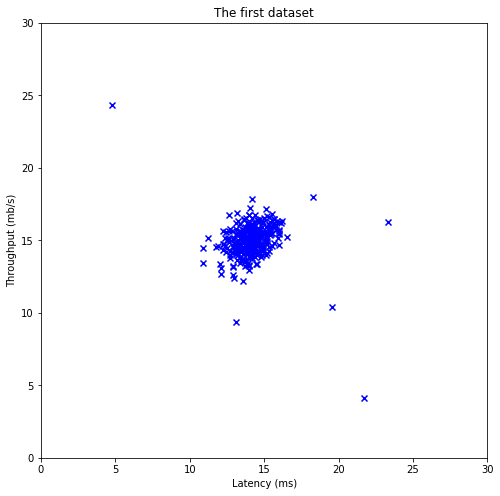

In [23]:
plt.figure(figsize=(8,8))
plt.scatter(X_train[:, 0], X_train[:, 1], marker='x', c='b')
plt.title("The first dataset")
plt.ylabel('Throughput (mb/s)')
plt.xlabel('Latency (ms)')
plt.axis([0, 30, 0, 30])
plt.show()

### 이상치 탐지 알고리즘의 원만한 성능을 확보하려면, 먼저 데이터셋의 분포를 따라 모델의 수식을 결정해야 합니다. (위 데이터셋 X_train은 정규분포(가우시안)를 따르고 있으므로) 확률함수 p에 대한 식은 아래와 같습니다.

$$\huge p(x ; \mu,\sigma ^2) = \frac{1}{\sqrt{2 \pi \sigma ^2}}\exp^{ - \frac{(x - \mu)^2}{2 \sigma ^2} }$$

   (where $\mu$ is the mean and $\sigma^2$ controls the variance.)

### 위의 확률함수는 데이터셋 X_train의 모든 특성에 대해 각각 따로 계산해야 합니다. 2차원 좌표이므로 두 개의 확률밀도함수가 나오겠지요.

### 아시겠지만 평균과 분산을 구하는 공식은 아래와 같습니다. 이를 파이썬 코드로 옮겨보겠습니다.

$$\huge \mu_i = \frac{1}{m} \sum_{j=1}^m x_i^{(j)}$$

$$\huge \sigma_i^2 = \frac{1}{m} \sum_{j=1}^m (x_i^{(j)} - \mu_i)^2$$

m은 데이터셋의 갯수, i는 특성(열), j는 각 데이터(행)를 나타냅니다.

In [24]:
def estimate_gaussian(X):
    """
    데이터셋의 특성별로 평균과 분산을 계산하여 리턴해주는 함수

    입력인자: X (np.ndarray) - (m행, n열) 크기의 데이터 행렬임

    함수의 리턴값:
        mu (ndarray): (n,) 특성(feature)별 평균
        var (ndarray): (n,) 특성별 분산
    """

    m, n = X.shape
    mu = mu = 1 / m * np.sum(X, axis = 0)
    var = 1 / m * np.sum((X - mu) ** 2, axis = 0)
    return mu, var

In [25]:
mu, var = estimate_gaussian(X_train)

print("특성1과 특성2의 평균:", mu)
print("특성1과 특성2의 분산:", var)

특성1과 특성2의 평균: [14.11222578 14.99771051]
특성1과 특성2의 분산: [1.83263141 1.70974533]


## 가우시안 분포 등고선을 그려보려고 합니다. 그 전에, 확률밀도함수 p를 계산하는 함수를 하나만 더 정의하겠습니다. var가 행렬이면 공분산 행렬로, var가 벡터면 각 차원의 분산값으로 취급합니다.

In [30]:
def multivariate_gaussian(X, mu, var):
    k = len(mu)

    if var.ndim == 1:
        var = np.diag(var)

    X = X - mu
    p = (2* np.pi)**(-k/2) * np.linalg.det(var)**(-0.5) * \
        np.exp(-0.5 * np.sum(np.matmul(X, np.linalg.pinv(var)) * X, axis=1))

    return p

### 이제 확률밀도함수 등고선을 시각화해보겠습니다.

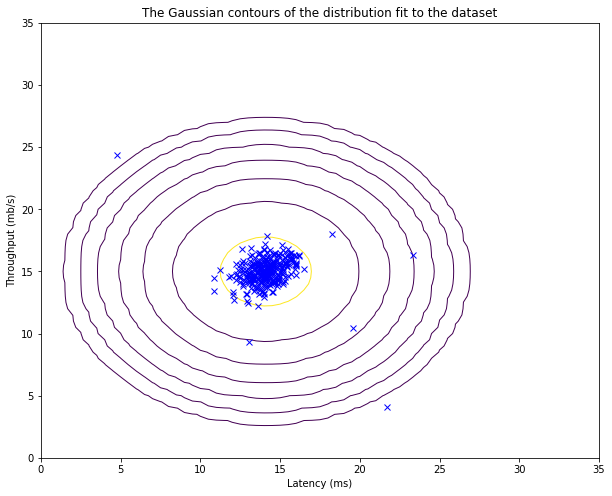

In [33]:
X1, X2 = np.meshgrid(np.arange(0, 35.5, 0.5), np.arange(0, 35.5, 0.5))
Z = multivariate_gaussian(np.stack([X1.ravel(), X2.ravel()], axis=1), mu, var)
Z = Z.reshape(X1.shape)

plt.figure(figsize=(10,8))
plt.plot(X_train[:, 0], X_train[:, 1], 'bx')

if np.sum(np.isinf(Z)) == 0:
    plt.contour(X1, X2, Z, levels=10**(np.arange(-20., 1, 3)), linewidths=1)

# Set the title
plt.title("The Gaussian contours of the distribution fit to the dataset")
# Set the y-axis label
plt.ylabel('Throughput (mb/s)')
# Set the x-axis label
plt.xlabel('Latency (ms)');

### 단순히 확률값에 따른 등고선을 그려보았습니다.이제 한 가지 결정할 것이 남아 있습니다. 확률값이 낮으면 이상치에 가까울텐데, 어느 정도로 중심에서 떨어져 있어야 이상치anomaly로 간주할지, **문턱값threshold**을 결정해야 합니다.